# TOPICS IN ARTIFICAL INTELLIGENCE PROJECT -2

## Problem Statement

Form a group of 2 or 3 students. Select a Kaggle.com competition either in vision or NLP, and make a research data analysis project using deep learning approaches. You should use your own initiative to define one or several research questions and use the resources available, based on the Python libraries (in particular Pytorch or Keras), to apply different deep learning approaches to this data to predict accurately the class of the unlabeled data and to answer your research questions. You should try to build a model as performant as possible for the selected task(s). You need to evaluate your model accuracy compared to other existing models. You need to evaluate how each properties/characteristic of your model affect the overall accuracy.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout, SimpleRNN, SpatialDropout2D
from sklearn import preprocessing as process
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

## STEP 1: Loading Yelp Dataset

In [2]:
yelp_data = pd.read_csv('../input/yelp-equalized-labels/yelp_equalized_lables_02.csv')

In [3]:
yelp_data['stars'] = yelp_data.stars.astype("int")
yelp_data.shape

(150000, 4)

In [4]:
yelp_data.head()

,Unnamed: 0,stars,text,target
0,0,5,I've taken a lot of spin classes over the year...,Positive
1,1,5,"Wow! Yummy, different, delicious. Our favo...",Positive
2,2,4,Cute interior and owner (?) gave us tour of up...,Positive
3,3,5,Loved this tour! I grabbed a groupon and the p...,Positive
4,4,5,Amazingly amazing wings and homemade bleu chee...,Positive


In [5]:
yelp_data.shape

(150000, 4)

In [6]:
yelp_data.head(10)

,Unnamed: 0,stars,text,target
0,0,5,I've taken a lot of spin classes over the year...,Positive
1,1,5,"Wow! Yummy, different, delicious. Our favo...",Positive
2,2,4,Cute interior and owner (?) gave us tour of up...,Positive
3,3,5,Loved this tour! I grabbed a groupon and the p...,Positive
4,4,5,Amazingly amazing wings and homemade bleu chee...,Positive
5,5,5,My experience with Shalimar was nothing but wo...,Positive
6,6,4,"Locals recommended Milktooth, and it's an amaz...",Positive
7,7,4,Love going here for happy hour or dinner! Gre...,Positive
8,8,4,Good food--loved the gnocchi with marinara\nth...,Positive
9,9,4,The bun makes the Sonoran Dog. It's like a snu...,Positive


Text(0, 0.5, 'Number of Reviews')

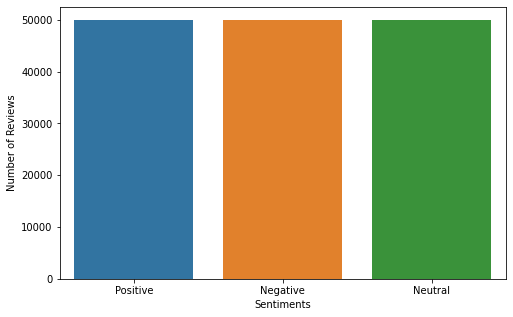

In [7]:
plot_df = yelp_data['target'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x = np.array(plot_df.index), y = np.array(plot_df.values))
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')

In [8]:
plot_df

Positive    50000
Negative    50000
Neutral     50000
Name: target, dtype: int64

In [9]:
'Review: ', yelp_data['text'][0]

('Review: ',
 "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).\n\nThere is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!")

## STEP 2: Dataset Preprocessing

In [10]:
yelp_data = yelp_data.dropna()

In [11]:
yelp_data['text'] = yelp_data['text'].apply(str.lower)

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [14]:
def is_en_word(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [15]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if is_en_word(word)]))

In [16]:
tokenizer = nltk.RegexpTokenizer(r"\w+")
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [17]:
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [18]:
words = set(nltk.corpus.words.words())
yelp_data['text'] = yelp_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word in words]))

**We can compare the review given above to the one below after preprocessing.**

In [19]:
'Review: ', yelp_data['text'][0]

('Review: ',
 'i taken lot spin classes nothing classes body cycle nice clean space amazing welcoming every class top notch work out anyone fit in system easy plan ahead and there s need line way advanced like many make do way write review without giving owner body cycle shout out s passion fitness cycling evident desire succeed always dropping classes check in provide encouragement open anyone always smile face even he s kicking butt class')

In [20]:
yelp_data.head()

,Unnamed: 0,stars,text,target
0,0,5,i taken lot spin classes nothing classes body ...,Positive
1,1,5,wow yummy different delicious favorite lamb cu...,Positive
2,2,4,cute interior owner gave us tour upcoming pati...,Positive
3,3,5,tour price great perfect way explore new someo...,Positive
4,4,5,amazingly amazing homemade cheese tender perfe...,Positive


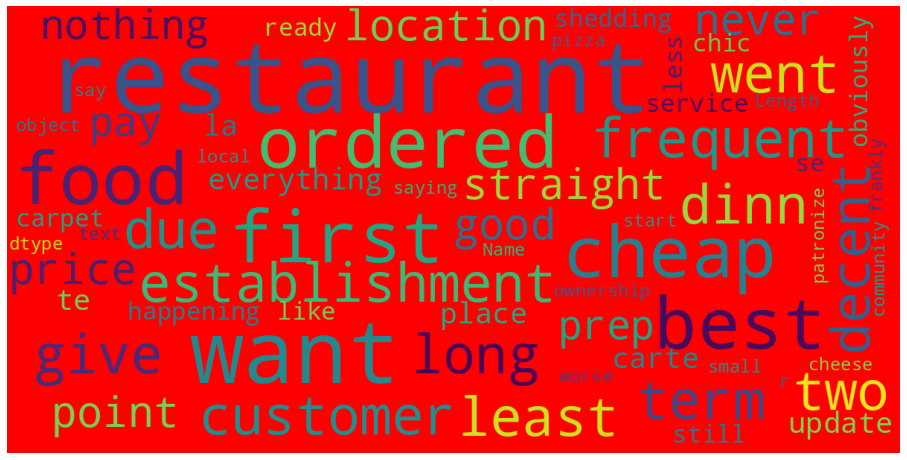

In [21]:
wordcloud = WordCloud(
    background_color='red',
    stopwords=stop_words,
    max_words=1000,
    max_font_size=45, 
    scale=3,
    random_state=1
).generate(str(yelp_data[yelp_data['stars'] < 3]['text']))

fig = plt.figure(1, figsize=(16, 16))
plt.axis('off') 
plt.imshow(wordcloud)
plt.show()

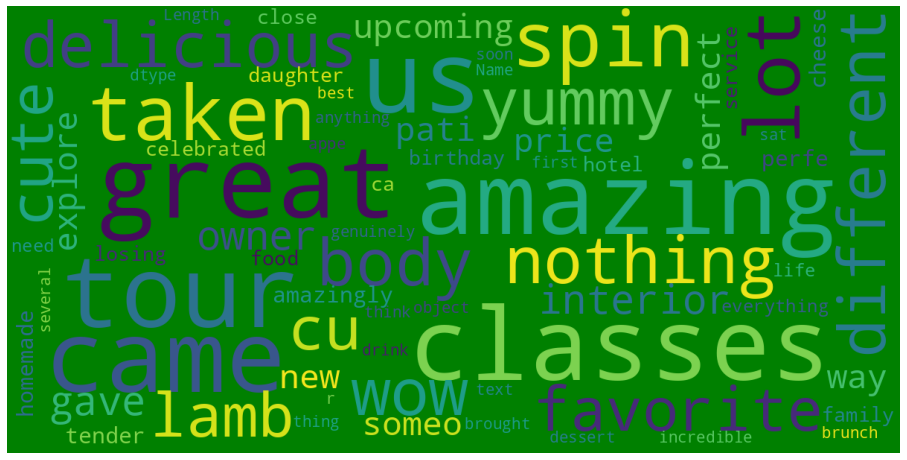

In [22]:
wordcloud = WordCloud(
    background_color='green',
    stopwords=stop_words,
    max_words=1000,
    max_font_size=45, 
    scale=3,
    random_state=1
).generate(str(yelp_data[yelp_data['stars'] > 3]['text']))

fig = plt.figure(1, figsize=(16, 16))
plt.axis('off') 
plt.imshow(wordcloud)
plt.show()

In [23]:
y = yelp_data['target'].to_numpy()

one_hot_encoder = OneHotEncoder().fit(y.reshape(-1, 1))
y_onehot = one_hot_encoder.transform(y.reshape(-1, 1))

In [24]:
y_onehot.shape

(150000, 3)

In [25]:
y[:31]

array(['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive'], dtype=object)

In [26]:
print(y_onehot.toarray()[:1])
print(y_onehot.toarray()[:-1])

[[0. 0. 1.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## STEP 3: Splitting dataset for training and testing

In [27]:
X_train, X_test, y_train, y_test = train_test_split(yelp_data['text'], y_onehot.toarray(), test_size=0.3, random_state=16)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105000,), (45000,), (105000, 3), (45000, 3))

Text(0, 0.5, 'Number of Reviews')

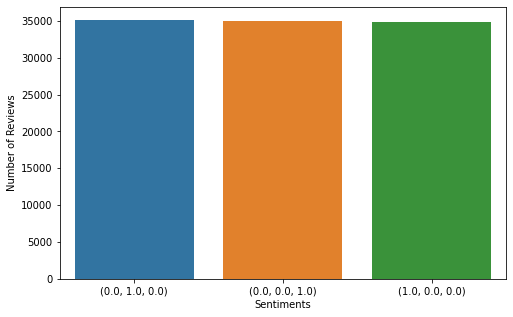

In [29]:
plot_df = pd.DataFrame(y_train).value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x = np.array(plot_df.index), y = np.array(plot_df.values))
plt.xlabel('Sentiments')
plt.ylabel('Number of Reviews')

In [30]:
plot_df

0    1    2  
0.0  1.0  0.0    35136
     0.0  1.0    34963
1.0  0.0  0.0    34901
dtype: int64

In [31]:
count_vect = Pipeline(
    [('vect', CountVectorizer(min_df=4)), ('reducer', SelectKBest(chi2, k=7000))]
)
X_train_counts = count_vect.fit_transform(X_train, y_train)

print(f'(Documents, Words) => {X_train_counts.shape}')

(Documents, Words) => (105000, 7000)


In [32]:
tfidf_transformer = TfidfTransformer(norm=None)

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(105000, 7000)


In [33]:
X_train_norm = process.normalize(X_train_tfidf, axis=0)

In [34]:
X_train_norm.shape

(105000, 7000)

In [35]:
arr1 = X_train_norm[10].toarray()
arr1[arr1 != 0]

array([0.01175008, 0.00797402, 0.01456637, 0.01270821, 0.00395439,
       0.01232784, 0.00734857, 0.0032329 , 0.03834825, 0.01171857])

In [36]:
X_train_norm = np.reshape(X_train_norm.toarray(), (X_train_norm.shape[0],1,X_train_norm.shape[1])) 
# X_train_norm = X_train_norm.toarray()

In [37]:
X_train_norm.shape

(105000, 1, 7000)

## STEP 4: Defining Models,Training, Results

In [38]:
model = Sequential()

model.add(LSTM(64,input_shape=(X_train_norm.shape[0], X_train_norm.shape[-1]),activation='elu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(32, recurrent_dropout=0.8, activation='elu'))
model.add(Dropout(0.8))

model.add(Dense(8,activation='elu'))
model.add(Dropout(0.4))

model.add(Dense(4,activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(2,activation='elu'))
model.add(Dropout(0.1))

model.add(Dense(3,activation='softmax'))

2022-04-26 13:57:15.529743: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 105000, 64)        1808640   
_________________________________________________________________
dropout (Dropout)            (None, 105000, 64)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 3

In [40]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [41]:
# from tensorflow import keras
# es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0)

In [42]:
# history = model.fit(X_train_norm, y_train, epochs=15, verbose=True, validation_split=0.33, batch_size=16, callbacks=[es_callback])
history = model.fit(X_train_norm, y_train, epochs=15, verbose=True, validation_split=0.33, batch_size=16)

2022-04-26 13:57:28.758260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
4397/4397 [==============================] - 71s 15ms/step - loss: 0.8612 - accuracy: 0.5732 - val_loss: 0.7155 - val_accuracy: 0.6630
Epoch 2/15
4397/4397 [==============================] - 57s 13ms/step - loss: 0.7430 - accuracy: 0.6556 - val_loss: 0.6820 - val_accuracy: 0.6841
Epoch 3/15
4397/4397 [==============================] - 58s 13ms/step - loss: 0.7009 - accuracy: 0.6867 - val_loss: 0.6624 - val_accuracy: 0.7092
Epoch 4/15
4397/4397 [==============================] - 59s 13ms/step - loss: 0.6700 - accuracy: 0.7096 - val_loss: 0.6678 - val_accuracy: 0.7167
Epoch 5/15
4397/4397 [==============================] - 59s 13ms/step - loss: 0.6443 - accuracy: 0.7244 - val_loss: 0.6796 - val_accuracy: 0.7211
Epoch 6/15
4397/4397 [==============================] - 58s 13ms/step - loss: 0.6338 - accuracy: 0.7321 - val_loss: 0.6988 - val_accuracy: 0.7209
Epoch 7/15
4397/4397 [==============================] - 58s 13ms/step - loss: 0.6227 - accuracy: 0.7395 - val_loss: 0.7130 -

In [55]:
X_test

111334    calling i better i m grateful manicure acrylic...
37281     drake great job cutting hair seen twice defini...
146403    well wife eat place get crowded pretty much wa...
148722    everyone speak highly place energy muster plac...
123815    standard chuck e cheese running around unatten...
                                ...                        
32412     stopped center city hungry sure craving sleek ...
72128     well could give place zero star grade would tr...
12357     truly magnificent venue beth hart concert last...
112281    small good couple tables average price small l...
38785                   crawfish delicious yr old spaghetti
Name: text, Length: 45000, dtype: object

In [56]:
X_new_counts = count_vect.transform(X_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
X_new_norm = process.normalize(X_new_tfidf, axis=0)
X_new_norm = np.reshape(X_new_norm.toarray(), (X_new_norm.shape[0],1,X_new_norm.shape[1]))
y_pred = model.predict(X_new_norm)

In [52]:
X_new_norm.shape

(45000, 1, 7000)

In [44]:
temp_pred = np.zeros_like(y_pred)
temp_pred

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [45]:
temp_pred[np.arange(len(y_pred)), y_pred.argmax(1)] = 1

In [46]:
pred_lab = one_hot_encoder.inverse_transform(temp_pred)
pred_lab.shape

(45000, 1)

In [47]:
test = []
for i in range(len(y_test)):
   test.append(np.argmax(y_test[i]))

test[:] = ["Negative" if x == 0 else x for x in test]
test[:] = ["Neutral" if x == 1 else x for x in test]
test[:] = ["Positive" if x == 2 else x for x in test]

test = np.array(test)
test.shape
test

array(['Neutral', 'Positive', 'Neutral', ..., 'Positive', 'Neutral',
       'Positive'], dtype='<U8')

In [48]:
print('ARCHITECTURE 1')
print('Precision Score: ', precision_score(test, pred_lab, average="macro"))
print('Recall Score: ', recall_score(test, pred_lab, average='macro'))
print('F1 Score: ',f1_score(test, pred_lab, average='macro'))
print('Accuracy Score: ',accuracy_score(test, pred_lab))

ARCHITECTURE 1
Precision Score:  0.7046808874892533
Recall Score:  0.7013975715733864
F1 Score:  0.7027929952775547
Accuracy Score:  0.7017777777777777
